In [1]:
"""
r: Zongyi Li and Daniel Zhengyu Huang
"""

import numpy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [6]:
def catheter_mesh_2d(x2, x3, h, ncy, ncx1, ncx2, ncx3, ncx4):
    x1 = 40
    # ncy = 20
    
    Ly = 20
    yy = torch.linspace(0, Ly, ncy+1, dtype=torch.float).to(device)

    Lx = 100
    # ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20
    ncx = ncx1 + ncx2 + ncx3 + ncx4
    # first generate 0-1, 1-2, 2-3, 3-4
    
    
    xx = torch.zeros(ncx+1, dtype=torch.float)
    xx[0:ncx1] = torch.linspace(0,  x1 - x1/ncx1, ncx1, dtype=torch.float)
    xx_ref = torch.linspace(0, 1-1/ncx2, ncx2)
    xx[ncx1:ncx1+ncx2] = x1*(1 - xx_ref) + ((x1+x3)/2) * xx_ref
    xx_ref = torch.linspace(0, 1-1/ncx3, ncx3)
    xx[ncx1+ncx2:ncx1+ncx2+ncx3] = (x1+x3)/2*(1 - xx_ref) + x3 * xx_ref
    xx_ref = torch.linspace(0, 1, ncx4+1)
    xx[ncx1+ncx2+ncx3:ncx1+ncx2+ncx3+ncx4+1] = x3*(1 - xx_ref) + Lx*xx_ref
    

    # Step 1
    
    yy_ones = torch.ones(ncy+1, dtype=torch.float)

    # X, Y = torch.meshgrid(xx, yy)
    X = torch.outer(torch.ones(ncy+1), xx )
    Y = torch.outer(yy, torch.ones(ncx+1)) 
    
    
    Y[:, ncx1:ncx1+ncx2] = torch.outer(yy, (Ly - 2*(X[0, ncx1:ncx1+ncx2] - x1)/((x1+x3)/2 - x1)*h)/Ly) + torch.outer(yy_ones,     (X[0, ncx1:ncx1+ncx2] - x1)/((x1+x3)/2 - x1)*h)
    Y[:, ncx1+ncx2:ncx1+ncx2+ncx3+1] = torch.outer(yy, (Ly - 2*(x3 - X[0, ncx1+ncx2:ncx1+ncx2+ncx3+1])/(x3 - (x1+x3)/2)*h)/Ly) + torch.outer(yy_ones,    (x3 - X[0, ncx1+ncx2:ncx1+ncx2+ncx3+1])/(x3 - (x1+x3)/2)*h)
  


    # Step 2

    dx1 = torch.zeros((ncy+1, ncx+1), dtype=torch.float).to(device)
    dx2 = torch.zeros((ncy+1, ncx+1), dtype=torch.float).to(device)
    dx = torch.zeros((ncy+1, ncx+1), dtype=torch.float).to(device)
    dy = torch.ones((ncy+1, ncx+1), dtype=torch.float).to(device) * h
    dx1[:, 0:ncx1+ncx2+1] = (x1+x3)/2 
    dx2[:, 0:ncx1+ncx2+1] = x1
    dx1[:, ncx1+ncx2:] = Lx-(x1+x3)/2
    dx2[:, ncx1+ncx2:] = Lx-x3

    dx[:, 0:ncx1+ncx2+1] = X[:, 0:ncx1+ncx2+1]
    dx[:, ncx1+ncx2:] = Lx - X[:, ncx1+ncx2:]

    dy[Y <= h] = Y[Y <= h]
    dy[Y >= Ly - h] = (Ly - Y[Y >= Ly - h])

    Delta_x_max = x2 - (x1 + x3)/2

    Delta_x = dx/(dx1*dy + (h - dy)*dx2) * dy * Delta_x_max
    X = X + Delta_x
        
    X_Y = torch.stack([torch.hstack([X[:, 0:ncx] - 100, X]), torch.hstack([Y[:, 0:ncx], Y])], dim=-1).unsqueeze(0)
    return X_Y, X, Y


def Theta2Mesh_2d(theta):
    x2, x3, h = theta
    ncy, ncx1, ncx2, ncx3, ncx4 = 100, 25, 25, 25, 25
    X_Y, X, Y = catheter_mesh_2d(x2, x3, h, ncy, ncx1, ncx2, ncx3, ncx4)
    return X_Y, X, Y





  
    dx1 = np.zeros(ncx+1)
    dx2 = np.zeros(ncx+1)
    dx  = np.zeros(ncx+1)
    
    dx1[0:ncx1+ncx2+1] = (x1+x3)/2 
    dx2[0:ncx1+ncx2+1] = x1
    dx1[ncx1+ncx2:]    = Lx-(x1+x3)/2
    dx2[ncx1+ncx2:]    = Lx-x3

    dx[ncx1+1:ncx1+ncx2] = xx[ncx1+1:ncx1+ncx2]
    dx[ncx1+ncx2:ncx1+ncx2+ncx3+1] = Lx - xx[ncx1+ncx2:ncx1+ncx2+ncx3+1]

    Delta_x_max = x2 - (x1 + x3)/2

    Delta_x = dx/(dx1*yy + (h - yy)*dx2) * yy * Delta_x_max
    xx = xx + Delta_x
    print(dx)
    if plot_or_not:
        plt.figure()
        plt.plot(xx, yy, "-or", fillstyle="none")

        plt.plot(bottom_x, bottom_y, "-b")

def catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4):
    x1 = 40
    # ncy = 20
    
    Ly = 20
    

    Lx = 100
    # ncx1, ncx2, ncx3, ncx4 = 20, 10, 10, 20
    ncx = ncx1 + ncx2 + ncx3 + ncx4
    
    xx = torch.zeros(ncx+1, dtype=torch.float)
    xx[0:ncx1] = torch.linspace(0,  x1 - x1/ncx1, ncx1, dtype=torch.float)
    xx_ref = torch.linspace(0, 1-1/ncx2, ncx2)
    xx[ncx1:ncx1+ncx2] = x1*(1 - xx_ref) + ((x1+x3)/2) * xx_ref
    xx_ref = torch.linspace(0, 1-1/ncx3, ncx3)
    xx[ncx1+ncx2:ncx1+ncx2+ncx3] = (x1+x3)/2*(1 - xx_ref) + x3 * xx_ref
    xx_ref = torch.linspace(0, 1, ncx4+1)
    xx[ncx1+ncx2+ncx3:ncx1+ncx2+ncx3+ncx4+1] = x3*(1 - xx_ref) + Lx*xx_ref
    
    yy = torch.zeros(ncx+1, dtype=torch.float).to(device)
    yy[ncx1:ncx1+ncx2] = (xx[ncx1:ncx1+ncx2] - x1)/((x1+x3)/2 - x1)*h
    yy[ncx1+ncx2:ncx1+ncx2+ncx3+1] = (x3 - xx[ncx1+ncx2:ncx1+ncx2+ncx3+1])/(x3 - (x1+x3)/2)*h
    

    dx1 = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx2 = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx = torch.zeros(ncx+1, dtype=torch.float).to(device)
    dx1[0:ncx1+ncx2+1] = (x1+x3)/2 
    dx2[0:ncx1+ncx2+1] = x1
    dx1[ncx1+ncx2:] = Lx-(x1+x3)/2
    dx2[ncx1+ncx2:] = Lx-x3

    dx[ncx1+1:ncx1+ncx2] = xx[ncx1+1:ncx1+ncx2]
    dx[ncx1+ncx2:ncx1+ncx2+ncx3+1] = Lx - xx[ncx1+ncx2:ncx1+ncx2+ncx3+1]

    Delta_x_max = x2 - (x1 + x3)/2

    Delta_x = dx/(dx1*yy + (h - yy)*dx2) * yy * Delta_x_max
    xx = xx + Delta_x
        
    X_Y = torch.stack([torch.hstack([xx[0:ncx] - 100, xx]), torch.hstack([yy[0:ncx], yy])], dim=-1).unsqueeze(0)
    return X_Y, xx, yy


def Theta2Mesh_1d(theta):
    x2, x3, h = theta
    ncx1, ncx2, ncx3, ncx4 = 50, 50, 50, 50
    X_Y, X, Y = catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4)
    return X_Y, X, Y

In [7]:
# check torch code
x2, x3, h = 40, 50, 5
ncy, ncx1, ncx2, ncx3, ncx4 = 10, 5, 2, 2, 5
X0,Y0 = numpy_catheter_mesh_2d(x2, x3, h, ncy, ncx1, ncx2, ncx3, ncx4, plot_or_not = False)
X_Y, X, Y = catheter_mesh_2d(x2, x3, h, ncy, ncx1, ncx2, ncx3, ncx4)

print("2d X error = ", np.linalg.norm(X0 - X.numpy()))
print("2d Y error = ", np.linalg.norm(Y0 - Y.numpy()))

x2, x3, h = 40, 50, 5
ncx1, ncx2, ncx3, ncx4 = 5, 2, 2, 5
X0,Y0 = numpy_catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4, plot_or_not = False)
X_Y, X, Y = catheter_mesh_1d(x2, x3, h, ncx1, ncx2, ncx3, ncx4)



print("1d X error = ", np.linalg.norm(X0 - X.numpy()))
print("1d Y error = ", np.linalg.norm(Y0 - Y.numpy()))

2d X error =  1.2834651485279689e-05
2d Y error =  0.0
[ 0.   0.   0.   0.   0.   0.  42.5 55.  52.5 50.   0.   0.   0.   0.
  0. ]
1d X error =  0.0
1d Y error =  0.0


2384857


/var/folders/sq/9dntw6953x7fn5kvr7xqnr680000gn/T/ipykernel_24737/1054184011.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  theta = torch.tensor(np.array([45,50,3], dtype=np.float), requires_grad=True)


0 0.47315430500003686 loss =  -314465.5625 reg =  67.3349834781297
x2, x3, h =  45.217196750854136 49.78252418783121 3.2153846932480055


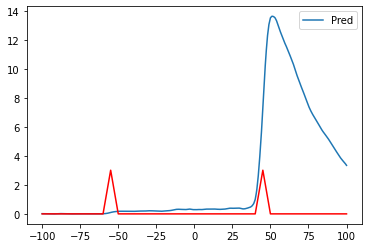

1 0.4002042800000254 loss =  -314926.5625 reg =  67.33468868272907
2 0.4166194160000032 loss =  -315349.3125 reg =  67.33442481971868
3 0.44283789600001455 loss =  -315748.1875 reg =  67.33417599967501
4 0.40478912899999386 loss =  -316128.40625 reg =  67.3339362085797
5 0.40931126199996015 loss =  -316492.6875 reg =  67.33370223184743
6 0.4010184440000444 loss =  -316842.8125 reg =  67.33347199562486
7 0.40434066999995366 loss =  -317180.1875 reg =  67.33324399980793
8 0.3996408389999715 loss =  -317505.9375 reg =  67.33301707202048
9 0.40801521299999877 loss =  -317821.1875 reg =  67.33279024121052
10 0.4090567469999655 loss =  -318126.875 reg =  67.33256266677616
11 0.44043326299998853 loss =  -318423.9375 reg =  67.33233359418794
12 0.41111272599999893 loss =  -318713.1875 reg =  67.33210232879297
13 0.4005704249999553 loss =  -318995.4375 reg =  67.33186822007185
14 0.4075001609999731 loss =  -319271.28125 reg =  67.33163065441101
15 0.39921465899999475 loss =  -319541.3125 reg = 

122 0.39564973599999576 loss =  -328617.8125 reg =  67.48448645223414
123 0.39542708499999435 loss =  -328720.46875 reg =  67.47945434729812
124 0.40303952499999696 loss =  -328824.125 reg =  67.47438575919938
125 0.3927961709999863 loss =  -328928.875 reg =  67.46928864376487
126 0.4041152270000339 loss =  -329034.59375 reg =  67.46416997060216
127 0.39951301600001443 loss =  -329141.375 reg =  67.45903582270337
128 0.3883467420000102 loss =  -329249.25 reg =  67.45389149866321
129 0.39552534000000605 loss =  -329358.09375 reg =  67.4487416149729
130 0.39759398399996826 loss =  -329467.9375 reg =  67.44359020858313
131 0.40020349299999225 loss =  -329578.59375 reg =  67.43844083661779
132 0.3988044530000252 loss =  -329690.0 reg =  67.43329667106337
133 0.3963756299999659 loss =  -329802.0 reg =  67.42816058559109
134 0.4001314830000524 loss =  -329914.5 reg =  67.42303523104327
135 0.39128769000001284 loss =  -330027.375 reg =  67.41792309739742
136 0.3964165149999985 loss =  -330140

242 0.4011833150000257 loss =  -347906.6875 reg =  67.00196023993666
243 0.4188290260000258 loss =  -348074.75 reg =  67.00063035274489
244 0.44695673500001476 loss =  -348246.78125 reg =  66.99936417312635
245 0.4336081820000004 loss =  -348422.46875 reg =  66.9981630593452
246 0.44594055799996113 loss =  -348601.8125 reg =  66.99702832292063
247 0.40587040299999444 loss =  -348784.0 reg =  66.99596125268394
248 0.4481004809999831 loss =  -348968.25 reg =  66.99496310213055
249 0.4059906530000035 loss =  -349153.875 reg =  66.9940350704526
250 0.4222124670000085 loss =  -349340.59375 reg =  66.99317826525238
251 0.40873120400004836 loss =  -349527.9375 reg =  66.99239364890174
252 0.4326998680000429 loss =  -349715.84375 reg =  66.99168197225636
253 0.42316406300000153 loss =  -349904.0625 reg =  66.99104370490438
254 0.39242910599995184 loss =  -350092.71875 reg =  66.99047897076767
255 0.3988568569999984 loss =  -350281.84375 reg =  66.9899874966007
256 0.4060388859999762 loss =  -3

361 0.39844908700001724 loss =  -351731.46875 reg =  67.2784817223004
362 0.3920473169999923 loss =  -351655.1875 reg =  67.28448369077731
363 0.39444818700002315 loss =  -351579.9375 reg =  67.29056103953921
364 0.4055635459999962 loss =  -351505.65625 reg =  67.29671557781114
365 0.4182550020000235 loss =  -351432.4375 reg =  67.30294909320561
366 0.4088452330000223 loss =  -351360.4375 reg =  67.30926334562145
367 0.4393699450000099 loss =  -351289.625 reg =  67.31566006150317
368 0.42879457200001525 loss =  -351219.90625 reg =  67.32214092710589
369 0.40855569699999705 loss =  -351151.5 reg =  67.32870758276475
370 0.3927696359999686 loss =  -351084.40625 reg =  67.33536161946313
371 0.44314373000003116 loss =  -351018.625 reg =  67.34210457555017
372 0.4140647240000135 loss =  -350954.25 reg =  67.34893793341251
373 0.480279988999996 loss =  -350891.34375 reg =  67.3558631176938
374 0.4271939619999898 loss =  -350830.0 reg =  67.36288149420781
375 0.4291367820000005 loss =  -35077

481 0.4126995760000227 loss =  -352912.1875 reg =  68.80984253603486
482 0.40366328700002896 loss =  -352978.125 reg =  68.83074525620988
483 0.40402838499994687 loss =  -353044.34375 reg =  68.8517389926879
484 0.4412043590000394 loss =  -353111.375 reg =  68.8728206862883
485 0.4182195729999876 loss =  -353179.75 reg =  68.89398756232168
486 0.4260014559999945 loss =  -353249.6875 reg =  68.91523716760734
487 0.41769913199999564 loss =  -353321.9375 reg =  68.93656740318491
488 0.4231187770000133 loss =  -353396.75 reg =  68.95797653761208
489 0.4265162120000241 loss =  -353474.375 reg =  68.97946320687763
490 0.43706236299999546 loss =  -353555.125 reg =  69.00102639826169
491 0.3900777869999956 loss =  -353639.0 reg =  69.02266541359279
492 0.40787691700001005 loss =  -353725.90625 reg =  69.04437981808594
493 0.3942451240000082 loss =  -353815.4375 reg =  69.06616937225435
494 0.3915674009999748 loss =  -353907.3125 reg =  69.08803395700939
495 0.3913460209999471 loss =  -353999.9

600 0.417141145999949 loss =  -367579.375 reg =  71.6544153492305
601 0.4083260559999644 loss =  -367793.875 reg =  71.6801953846347
602 0.40779088699991917 loss =  -368010.5625 reg =  71.70600389788038
603 0.4067112630000338 loss =  -368231.25 reg =  71.73184035928547
604 0.4108644919999733 loss =  -368457.0625 reg =  71.75770435970456
605 0.40326244099992437 loss =  -368688.4375 reg =  71.7835956403978
606 0.39697214199998143 loss =  -368926.0625 reg =  71.8095141048549
607 0.40280187399991974 loss =  -369170.21875 reg =  71.83545982222967
608 0.41145573699998295 loss =  -369420.8125 reg =  71.86143301518746
609 0.4050577909999902 loss =  -369678.125 reg =  71.88743403984869
610 0.40876951500001724 loss =  -369941.65625 reg =  71.91346335642213
611 0.410269674999995 loss =  -370211.15625 reg =  71.93952149946671
612 0.4066154719999986 loss =  -370486.59375 reg =  71.96560905101092
613 0.4117804589999423 loss =  -370767.90625 reg =  71.99172661275286
614 0.41169887799992466 loss =  -3

719 0.41900804800002334 loss =  -406676.1875 reg =  74.87897609443337
720 0.4147861249999778 loss =  -406866.6875 reg =  74.90601390423579
721 0.414478680000002 loss =  -407032.1875 reg =  74.93302539057227
722 0.41239387500002067 loss =  -407252.0625 reg =  74.96000994161274
723 0.4127362770000218 loss =  -407516.53125 reg =  74.98696694229355
724 0.41456670499997017 loss =  -407651.5625 reg =  75.01389575105648
725 0.4076188679999859 loss =  -407812.75 reg =  75.04079572374603
726 0.4172624459999952 loss =  -407944.125 reg =  75.06766622069824
727 0.4086234820000527 loss =  -408108.65625 reg =  75.09450660080141
728 0.414196727999979 loss =  -408286.625 reg =  75.12131623598752
729 0.4243202019999899 loss =  -408413.5 reg =  75.14809452514034
730 0.41621288099997855 loss =  -408516.3125 reg =  75.17484088280175
731 0.4144228000000112 loss =  -408613.375 reg =  75.20155475129698
732 0.42499062299998513 loss =  -408773.0 reg =  75.22823558014129
733 0.409411791000025 loss =  -408900.46

839 0.43496809999999186 loss =  -398073.75 reg =  77.83175287700762
840 0.4364757680000366 loss =  -397995.0625 reg =  77.85358579515459
841 0.4316487229999666 loss =  -397873.375 reg =  77.87537031643149
842 0.4357889460000024 loss =  -397742.40625 reg =  77.89710635073729
843 0.4347756209999716 loss =  -397592.9375 reg =  77.91879381794487
844 0.44529161200000544 loss =  -397418.125 reg =  77.94043264370629
845 0.4886854190000349 loss =  -397318.46875 reg =  77.9620227647184
846 0.47185727800001587 loss =  -397199.75 reg =  77.98356413071095
847 0.47187282800007324 loss =  -397102.28125 reg =  78.00505670166608
848 0.45827717599991047 loss =  -396985.40625 reg =  78.02650044682913
849 0.45583225099994706 loss =  -396798.6875 reg =  78.04789534059522
850 0.4444784969999773 loss =  -396714.875 reg =  78.06924136432963
851 0.43792013600000246 loss =  -396590.46875 reg =  78.09053850793114
852 0.4306804860000284 loss =  -396488.25 reg =  78.11178676403092
853 0.4465115740000556 loss =  -

958 0.48504687600006946 loss =  -398368.875 reg =  80.07553206904174
959 0.4492784299999357 loss =  -398539.75 reg =  80.09125239892165
960 0.4380027350000546 loss =  -398696.96875 reg =  80.10691967004638
961 0.44836802200006787 loss =  -398872.8125 reg =  80.12253387180128
962 0.4782075079999686 loss =  -399039.375 reg =  80.13809499807805
963 0.47448758500001986 loss =  -399231.09375 reg =  80.1536030435397
964 0.44131779500003177 loss =  -399422.125 reg =  80.16905800912984
965 0.43965095800001563 loss =  -399595.6875 reg =  80.18445989780747
966 0.4574837119999984 loss =  -399783.0625 reg =  80.1998087136033
967 0.4439250960000436 loss =  -399972.75 reg =  80.21510446444285
968 0.45665601700000025 loss =  -400238.25 reg =  80.23034716215258
969 0.4408881240000255 loss =  -400386.875 reg =  80.2455368197915
970 0.42941640399999415 loss =  -400559.9375 reg =  80.26067345158162
971 0.4631546170001002 loss =  -400759.0625 reg =  80.27575707754609
972 0.4632446589999972 loss =  -401642

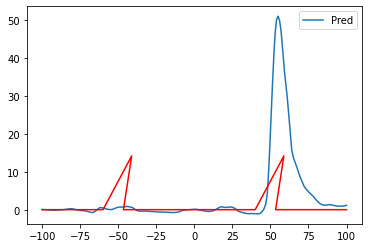

1001 0.47021719600002143 loss =  -408784.4375 reg =  80.69705242192799
1002 0.43741260600006626 loss =  -408990.6875 reg =  80.7037837759547
1003 0.48139818699996795 loss =  -409106.625 reg =  80.71048898051933
1004 0.4761903179999081 loss =  -409238.53125 reg =  80.71716807743503
1005 0.4498357140000735 loss =  -409371.3125 reg =  80.72382110893345
1006 0.49552035600004274 loss =  -409520.125 reg =  80.73044811777979
1007 0.501010539000049 loss =  -409629.125 reg =  80.73704914831194
1008 0.45695765199991456 loss =  -409749.375 reg =  80.74362424286171
1009 0.4461297820000709 loss =  -409895.125 reg =  80.75017344380645
1010 0.4458289919999743 loss =  -410032.3125 reg =  80.75669679603517
1011 0.44051113600005465 loss =  -410124.34375 reg =  80.76319434548967
1012 0.4441481329999988 loss =  -410321.0625 reg =  80.76966613877458
1013 0.44796621900002265 loss =  -410476.15625 reg =  80.77611222244646
1014 0.4452699880000637 loss =  -410601.5 reg =  80.78253264537184
1015 0.4478680720000

1118 0.4730967420000525 loss =  -426111.25 reg =  81.3292275319332
1119 0.4402361759999849 loss =  -426224.1875 reg =  81.33360201682255
1120 0.47671051600002556 loss =  -426169.0 reg =  81.33796639625194
1121 0.4855771329999925 loss =  -426258.1875 reg =  81.34232089789992
1122 0.47972402799996416 loss =  -426354.5 reg =  81.34666574583267
1123 0.4947672360000297 loss =  -426463.5 reg =  81.35100115897494
1124 0.4879623399999673 loss =  -426520.875 reg =  81.35532735313019
1125 0.48001470600001994 loss =  -426622.59375 reg =  81.35964453236822
1126 0.4676048669999773 loss =  -426741.5625 reg =  81.36395289879198
1127 0.45895207399996707 loss =  -426799.65625 reg =  81.36825265455025
1128 0.4783545469999808 loss =  -426857.125 reg =  81.37254399715319
1129 0.47073282899998503 loss =  -426991.53125 reg =  81.37682711904851
1130 0.45341195499997866 loss =  -427079.875 reg =  81.38110220569713
1131 0.43737107300000844 loss =  -427165.84375 reg =  81.38536944305739
1132 0.4747668380000505 

1236 0.4882141310000634 loss =  -426735.75 reg =  81.8259391678805
1237 0.44985003099998266 loss =  -426704.1875 reg =  81.83039976290895
1238 0.4937981589999936 loss =  -426642.1875 reg =  81.83487106732902
1239 0.45597332900001675 loss =  -426594.625 reg =  81.83935321299977
1240 0.46038891000000604 loss =  -426550.1875 reg =  81.8438463249859
1241 0.45159096199995474 loss =  -426541.09375 reg =  81.84835052528294
1242 0.44500917000004847 loss =  -426502.28125 reg =  81.85286593737813
1243 0.4498232340000641 loss =  -426468.78125 reg =  81.8573926826472
1244 0.4461119720000397 loss =  -426425.15625 reg =  81.86193088072136
1245 0.46696858200004954 loss =  -426376.40625 reg =  81.86648065111709
1246 0.4435974929999702 loss =  -426361.375 reg =  81.87104211603184
1247 0.437369106999995 loss =  -426333.4375 reg =  81.87561539267027
1248 0.44173155700002553 loss =  -426296.15625 reg =  81.88020059937746
1249 0.442982665000045 loss =  -426259.25 reg =  81.88479785430584
1250 0.44727386899

1354 0.476947680999956 loss =  -421191.65625 reg =  82.45443565159177
1355 0.4812892740000052 loss =  -421150.3125 reg =  82.46083368018088
1356 0.4671585780000669 loss =  -421142.125 reg =  82.46725206298076
1357 0.4507269879999285 loss =  -421128.125 reg =  82.47369083648535
1358 0.4724019150000913 loss =  -421112.3125 reg =  82.48015003841007
1359 0.477305423999951 loss =  -421049.625 reg =  82.4866297022615
1360 0.4888793850000184 loss =  -421035.5625 reg =  82.49312986428042
1361 0.5025239200000442 loss =  -420997.8125 reg =  82.49965056213156
1362 0.48574212799996985 loss =  -420983.0625 reg =  82.50619183174763
1363 0.4748828120000326 loss =  -420968.4375 reg =  82.51275371230946
1364 0.4794827279999936 loss =  -420975.71875 reg =  82.51933624115415
1365 0.44854484300003605 loss =  -420921.25 reg =  82.52593945459991
1366 0.4797520680000389 loss =  -420932.6875 reg =  82.53256338762701
1367 0.4465131779999183 loss =  -420924.4375 reg =  82.5392080769454
1368 0.4585682640000641 l

1472 0.4557274750000033 loss =  -420101.21875 reg =  83.35646885920305
1473 0.44477179000000433 loss =  -420107.96875 reg =  83.3653817427573
1474 0.45403360300008444 loss =  -420145.28125 reg =  83.37431423368959
1475 0.4540385499999502 loss =  -420159.09375 reg =  83.38326621927332
1476 0.45590872999991916 loss =  -420157.8125 reg =  83.39223758538246
1477 0.44737974100007705 loss =  -420192.4375 reg =  83.40122821776326
1478 0.44858503900002233 loss =  -420199.03125 reg =  83.41023800011286
1479 0.45037801000000854 loss =  -420217.3125 reg =  83.41926681583774
1480 0.44664336300002105 loss =  -420238.09375 reg =  83.42831454677845
1481 0.4539532370000643 loss =  -420230.25 reg =  83.43738107127383
1482 0.4438608299999487 loss =  -420237.71875 reg =  83.44646626577632
1483 0.4507946730000185 loss =  -420245.5 reg =  83.45557000735316
1484 0.447367598000028 loss =  -420267.3125 reg =  83.46469217368553
1485 0.4500517010000067 loss =  -420282.125 reg =  83.4738326425233
1486 0.44672458

1590 0.45557844899997235 loss =  -422327.5625 reg =  84.51154828428844
1591 0.46455525099997885 loss =  -422356.53125 reg =  84.52194329159408
1592 0.4506745379999302 loss =  -422385.9375 reg =  84.53234480993092
1593 0.4622905549999814 loss =  -422415.125 reg =  84.54275285604243
1594 0.46330934000002344 loss =  -422445.375 reg =  84.55316745060142
1595 0.4519540999999663 loss =  -422476.875 reg =  84.5635886187249
1596 0.4623830520000638 loss =  -422508.0625 reg =  84.57401639051545
1597 0.4596488089999866 loss =  -422539.03125 reg =  84.58445079980066
1598 0.4517402410000386 loss =  -422571.90625 reg =  84.59489188280017
1599 0.4536416629999849 loss =  -422584.78125 reg =  84.60533967972187
1600 0.45692629799998485 loss =  -422597.5625 reg =  84.61579423423768
1601 0.4506986339999912 loss =  -422632.4375 reg =  84.62625559521358
1602 0.451573145999987 loss =  -422666.40625 reg =  84.63672381180969
1603 0.4505530459999818 loss =  -422700.875 reg =  84.64719893408974
1604 0.4545030870

1707 0.4542294509999465 loss =  -426821.96875 reg =  85.77118221414617
1708 0.4738368309999714 loss =  -426859.875 reg =  85.7822073909768
1709 0.4649186480000935 loss =  -426907.46875 reg =  85.79323422396129
1710 0.46776893099990957 loss =  -426959.3125 reg =  85.80426263941283
1711 0.466743852000036 loss =  -426977.625 reg =  85.81529256101418
1712 0.4598509659999763 loss =  -427014.4375 reg =  85.82632391219514
1713 0.46900727699994604 loss =  -427064.0625 reg =  85.83735661420157
1714 0.5143170359999658 loss =  -427107.25 reg =  85.84839058613555
1715 0.47803315400005886 loss =  -427173.53125 reg =  85.8594257477918
1716 0.45177713499992933 loss =  -427229.65625 reg =  85.87046201731224
1717 0.4607544699999835 loss =  -427240.84375 reg =  85.88149931089575
1718 0.466930186999889 loss =  -427298.0625 reg =  85.89253754527887
1719 0.452901256000132 loss =  -427349.71875 reg =  85.90357663487153
1720 0.45039252600008695 loss =  -427386.0625 reg =  85.91461649174889
1721 0.45935999599

1825 0.46412048800016237 loss =  -432031.15625 reg =  87.06171239773943
1826 0.468776969000146 loss =  -432052.15625 reg =  87.07242658935272
1827 0.4612237470000764 loss =  -432107.84375 reg =  87.08313592841455
1828 0.46449662000009084 loss =  -432150.3125 reg =  87.09384039730365
1829 0.467977411999982 loss =  -432173.5 reg =  87.10453997617914
1830 0.46704978499997196 loss =  -432227.3125 reg =  87.11523464752183
1831 0.47329355900001246 loss =  -432270.21875 reg =  87.12592439304649
1832 0.4594454130001395 loss =  -432293.75 reg =  87.1366091938065
1833 0.46719302399992557 loss =  -432343.5 reg =  87.14728903186999
1834 0.4629061549999278 loss =  -432578.625 reg =  87.15796388670502
1835 0.4699201509999966 loss =  -432623.40625 reg =  87.16863372091197
1836 0.4643367030000718 loss =  -432655.75 reg =  87.17929850161423
1837 0.466068574000019 loss =  -432678.5625 reg =  87.18995819621321
1838 0.4663667950001127 loss =  -432718.0625 reg =  87.20061277631316
1839 0.46303692099991167 

1943 0.46859546900009263 loss =  -435582.125 reg =  88.28155553549738
1944 0.4715276259998973 loss =  -435549.3125 reg =  88.29137101088516
1945 0.4680205140000453 loss =  -435519.71875 reg =  88.30117503949747
1946 0.46910871000000043 loss =  -435509.34375 reg =  88.31096754731101
1947 0.47231476699994346 loss =  -435543.0 reg =  88.32074845940127
1948 0.47380539200003113 loss =  -435603.5 reg =  88.33051770271167
1949 0.4694474909999826 loss =  -435558.5625 reg =  88.3402752117686
1950 0.4667808669998976 loss =  -435537.25 reg =  88.35002092365882
1951 0.4754928859999836 loss =  -435531.4375 reg =  88.35975477484142
1952 0.46909903400000985 loss =  -435546.25 reg =  88.3694766988232
1953 0.4686161520000951 loss =  -435516.5 reg =  88.37918662850504
1954 0.47672079499989195 loss =  -435574.125 reg =  88.38888449532872
1955 0.4590024930000709 loss =  -435550.34375 reg =  88.39857023032269
1956 0.4873816499998611 loss =  -435583.75 reg =  88.40824376469628
1957 0.4951541149998775 loss =

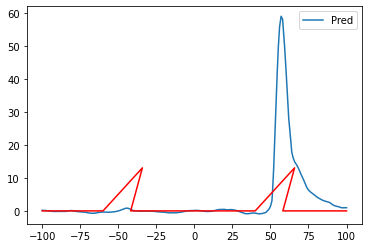

2001 0.5123159479999231 loss =  -434680.375 reg =  88.82538172998608
2002 0.5004488209999636 loss =  -434674.1875 reg =  88.82990562523742
2003 0.48105566699996416 loss =  -434674.375 reg =  88.8344221086937
2004 0.5041053120000925 loss =  -434663.125 reg =  88.83893117060771
2005 0.4742924970000786 loss =  -434664.15625 reg =  88.8434328016692
2006 0.5057218099998408 loss =  -434658.3125 reg =  88.84792699406823
2007 0.5037337030000799 loss =  -434671.4375 reg =  88.85241374121388
2008 0.502978652000138 loss =  -434616.4375 reg =  88.85689303714317
2009 0.487788799999862 loss =  -434598.25 reg =  88.86136487799229
2010 0.49960784599988983 loss =  -434580.09375 reg =  88.86582926055966
2011 0.4878025500001968 loss =  -434561.9375 reg =  88.8702861822331
2012 0.49677097999983744 loss =  -434543.875 reg =  88.87473564092464
2013 0.4768520279999393 loss =  -434525.8125 reg =  88.87917763501189
2014 0.4784570879999137 loss =  -434495.15625 reg =  88.88361216328474
2015 0.47730365500001426 

2119 0.5131077000000914 loss =  -432986.375 reg =  89.30753684787453
2120 0.48988093600019056 loss =  -432976.25 reg =  89.31117229568034
2121 0.5470860069999617 loss =  -432964.46875 reg =  89.31479996047325
2122 0.5417721290000372 loss =  -432899.5625 reg =  89.31841983146623
2123 0.5315562950002004 loss =  -432900.5625 reg =  89.3220318988701
2124 0.537329057000079 loss =  -432925.4375 reg =  89.32563615334064
2125 0.5289483540000219 loss =  -432922.3125 reg =  89.3292325847606
2126 0.5064382909999949 loss =  -432911.0 reg =  89.33282118246427
2127 0.542580566999959 loss =  -432912.34375 reg =  89.33640193597131
2128 0.5591345840000486 loss =  -432903.34375 reg =  89.33997483528803
2129 0.5032294449999881 loss =  -432892.3125 reg =  89.34353987092415
2130 0.5054660189998685 loss =  -432881.4375 reg =  89.34709703343393
2131 0.5406933140000092 loss =  -432858.0625 reg =  89.35064631340614
2132 0.5276977649998571 loss =  -432859.875 reg =  89.35418770112246
2133 0.5357951690000391 los

2237 0.49180573000012373 loss =  -432091.28125 reg =  89.68003189608908
2238 0.5072273000000678 loss =  -432104.1875 reg =  89.68267401793523
2239 0.4858134420001079 loss =  -432091.46875 reg =  89.68530697079795
2240 0.5084630740000193 loss =  -432104.65625 reg =  89.68793074223521
2241 0.5205049689998305 loss =  -432105.125 reg =  89.69054532009203
2242 0.5004541870000594 loss =  -432049.5 reg =  89.69315069211774
2243 0.5020350270001472 loss =  -432050.125 reg =  89.69574684566037
2244 0.48075350099998104 loss =  -432063.8125 reg =  89.6983337680268
2245 0.4712321129998145 loss =  -432051.75 reg =  89.70091144684024
2246 0.4690219579999848 loss =  -432052.75 reg =  89.70347986930403
2247 0.4766679640001712 loss =  -432066.875 reg =  89.70603902259758
2248 0.48381336499983263 loss =  -432055.15625 reg =  89.70858889422742
2249 0.47461047599995254 loss =  -432069.46875 reg =  89.71112947129902
2250 0.47363526999993155 loss =  -432057.96875 reg =  89.71366074125316
2251 0.4753096970000

2355 0.4910842369999955 loss =  -432729.75 reg =  89.92530401203689
2356 0.4821044249999886 loss =  -432744.75 reg =  89.92678467510538
2357 0.4776408149998588 loss =  -432759.9375 reg =  89.92825495034593
2358 0.47324904100014464 loss =  -432762.4375 reg =  89.92971483302244
2359 0.47482368700002553 loss =  -432790.625 reg =  89.93116431807906
2360 0.4775733379999565 loss =  -432793.4375 reg =  89.93260340112755
2361 0.47008504999985234 loss =  -432821.875 reg =  89.93403207745477
2362 0.4813468280001416 loss =  -432837.71875 reg =  89.93545034301454
2363 0.4773082740000518 loss =  -432840.9375 reg =  89.93685819390613
2364 0.48167069300006915 loss =  -432857.03125 reg =  89.9382556258976
2365 0.47853846900011376 loss =  -432886.0 reg =  89.93964263495012
2366 0.48500102999992123 loss =  -432889.6875 reg =  89.94101921769234
2367 0.520050572999935 loss =  -432918.90625 reg =  89.94238537041566
2368 0.5314825850000489 loss =  -432922.8125 reg =  89.94374109008066
2369 0.527990896999881

2473 0.4903651399999944 loss =  -435316.84375 reg =  90.02855964775809
2474 0.47727298099994186 loss =  -435347.59375 reg =  90.02883608055288
2475 0.49127545700002884 loss =  -435367.40625 reg =  90.02910309579231
2476 0.4917570180000439 loss =  -435398.46875 reg =  90.02936072079899
2477 0.488413219999984 loss =  -435440.6875 reg =  90.0296089834208
2478 0.48874401099988063 loss =  -435460.84375 reg =  90.02984791282674
2479 0.4794834249998985 loss =  -435492.1875 reg =  90.0300775378206
2480 0.48249103099988133 loss =  -435523.6875 reg =  90.03029788772749
2481 0.48081187100001443 loss =  -435566.21875 reg =  90.03050899239079
2482 0.47876781600007234 loss =  -435586.875 reg =  90.03071088298938
2483 0.49377025600006164 loss =  -435629.5625 reg =  90.03090359030422
2484 0.49127568699987023 loss =  -435661.375 reg =  90.03108714646402
2485 0.4900608339999053 loss =  -435682.5 reg =  90.03126158402725
2486 0.49165419600012683 loss =  -435725.375 reg =  90.03142693514043
2487 0.4848807

2591 0.4785931399999299 loss =  -439618.0 reg =  90.00657954962877
2592 0.48148380099996757 loss =  -439633.3125 reg =  90.00603195163671
2593 0.4847601599999507 loss =  -439666.4375 reg =  90.0054802792286
2594 0.4803395700000692 loss =  -439699.5 reg =  90.00492457813002
2595 0.4847025000001395 loss =  -439725.71875 reg =  90.00436489385959
2596 0.474152186000083 loss =  -439765.375 reg =  90.00380127065314
2597 0.48072331100001975 loss =  -439791.5625 reg =  90.0032337537552
2598 0.47050319100003435 loss =  -439824.4375 reg =  90.00266238712305
2599 0.4874070500000016 loss =  -439857.15625 reg =  90.00208721463746
2600 0.4741296639999746 loss =  -439896.3125 reg =  90.00150828010115
2601 0.4737187539999468 loss =  -439928.8125 reg =  90.00092562834215
2602 0.481330552999907 loss =  -439961.34375 reg =  90.00033930399245
2603 0.47760818899996593 loss =  -439993.75 reg =  89.99974935149488
2604 0.4848476590000246 loss =  -440026.0625 reg =  89.99915581511064
2605 0.480891186000008 los

2709 0.47957730999996784 loss =  -442776.5 reg =  89.92487109418335
2710 0.514286168000126 loss =  -442794.5 reg =  89.92411922115326
2711 0.4754707370000233 loss =  -442810.0625 reg =  89.9233677473345
2712 0.4787230009999348 loss =  -442838.34375 reg =  89.92261670480275
2713 0.4885469230000581 loss =  -442854.625 reg =  89.921866124924
2714 0.48738494200006244 loss =  -442872.375 reg =  89.92111603825192
2715 0.478306615000065 loss =  -442886.8125 reg =  89.92036647340386
2716 0.48787648200004696 loss =  -442904.40625 reg =  89.91961745959567
2717 0.5229563330001383 loss =  -442918.25 reg =  89.91886902418419
2718 0.4766967860000477 loss =  -442921.625 reg =  89.91812119520323
2719 0.49541538100015714 loss =  -442936.9375 reg =  89.91737400058007
2720 0.48790340699997614 loss =  -442952.0625 reg =  89.91662746760794
2721 0.4727383130000362 loss =  -442967.125 reg =  89.91588162298001
2722 0.5017415219999748 loss =  -442984.1875 reg =  89.9151364928227
2723 0.4786526180000692 loss = 

2827 0.4925481029999901 loss =  -443893.8125 reg =  89.84394835718777
2828 0.48281550800015793 loss =  -443906.6875 reg =  89.84335541164756
2829 0.49274335699988114 loss =  -443908.65625 reg =  89.84276439186687
2830 0.4723090580000644 loss =  -443899.21875 reg =  89.84217530742258
2831 0.48061975899986464 loss =  -443916.1875 reg =  89.84158817054151
2832 0.4866907190000802 loss =  -443917.625 reg =  89.84100299438387
2833 0.4825266020000072 loss =  -443931.0 reg =  89.84041979204153
2834 0.4852021589999822 loss =  -443920.625 reg =  89.83983857344609
2835 0.4844116619999568 loss =  -443933.625 reg =  89.83925935118019
2836 0.4766997699998683 loss =  -443934.75 reg =  89.83868213546509
2837 0.47493411799996466 loss =  -443923.625 reg =  89.83810693678645
2838 0.5081751989998793 loss =  -443924.375 reg =  89.83753376824058
2839 0.4773351339999863 loss =  -443937.40625 reg =  89.83696264289497
2840 0.4964092449999953 loss =  -443938.0625 reg =  89.83639357143888
2841 0.4776429859998643

2945 0.489744784000095 loss =  -443511.375 reg =  89.79051245515552
2946 0.4846896909998577 loss =  -443503.6875 reg =  89.79023152991518
2947 0.48674269000002823 loss =  -443519.5625 reg =  89.78995399102624
2948 0.49385593299984976 loss =  -443511.9375 reg =  89.78967984884325
2949 0.48350514699995983 loss =  -443186.75 reg =  89.78940911374264
2950 0.4805766570000287 loss =  -443178.4375 reg =  89.78914180951588
2951 0.47540077099984046 loss =  -443191.5625 reg =  89.78887795854428
2952 0.47883893099992747 loss =  -443144.25 reg =  89.78861758077798
2953 0.484879052999986 loss =  -443135.875 reg =  89.78836069714139
2954 0.4783718849998877 loss =  -443127.4375 reg =  89.78810732738772
2955 0.5026663700000427 loss =  -443119.03125 reg =  89.78785749020474
2956 0.47646785000006275 loss =  -443132.40625 reg =  89.787611203305
2957 0.4852025830000457 loss =  -443102.15625 reg =  89.78736848238935
2958 0.47696579400007977 loss =  -443115.6875 reg =  89.7871293435803
2959 0.47890692500004

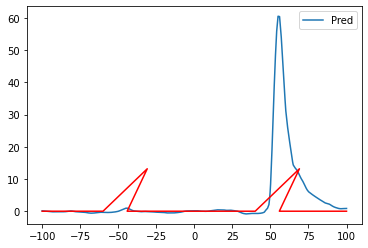

3001 0.4899943919999714 loss =  -442761.875 reg =  89.78042248674622
3002 0.4821264079998855 loss =  -442733.5 reg =  89.78038635991264
3003 0.5067006260001108 loss =  -442755.125 reg =  89.78035213685983
3004 0.48249506599995584 loss =  -442726.75 reg =  89.78031981910495
3005 0.4836935319999611 loss =  -442723.5 reg =  89.7802894084538
3006 0.49969074900013766 loss =  -442720.25 reg =  89.78026090651292
3007 0.4833850159998292 loss =  -442717.0 reg =  89.78023431470973
3008 0.47495852600013677 loss =  -442739.0 reg =  89.78020963431051
3009 0.4894926199999645 loss =  -442710.71875 reg =  89.78018686598145
3010 0.4850207299998601 loss =  -442732.875 reg =  89.7801660107614
3011 0.48317137999993065 loss =  -442729.90625 reg =  89.78014706911301
3012 0.48203916699981164 loss =  -442726.9375 reg =  89.78013004143695
3013 0.47054984800001876 loss =  -442724.0625 reg =  89.7801149280783
3014 0.4750301550000131 loss =  -442695.84375 reg =  89.78010172933263
3015 0.4811666630000673 loss =  -

3119 0.4830877500000952 loss =  -443069.875 reg =  89.78936485790493
3120 0.49109938400010833 loss =  -443072.6875 reg =  89.78955363586121
3121 0.5011339160000716 loss =  -443044.875 reg =  89.789744261851
3122 0.47755271599999105 loss =  -443047.75 reg =  89.78993673477036
3123 0.4937650050001139 loss =  -443050.6875 reg =  89.79013105353845
3124 0.485091366000006 loss =  -443084.4375 reg =  89.79032721709311
3125 0.48435787699986577 loss =  -443087.53125 reg =  89.79052522392043
3126 0.49096372600001814 loss =  -443026.6875 reg =  89.79072507256511
3127 0.4832658259999789 loss =  -443029.875 reg =  89.7909267622684
3128 0.4955988039998829 loss =  -443033.125 reg =  89.79113029224926
3129 0.4808800929999961 loss =  -443075.9375 reg =  89.7913356617047
3130 0.48780605199999627 loss =  -443112.96875 reg =  89.79154286961585
3131 0.49569388500003697 loss =  -443084.8125 reg =  89.79175191483465
3132 0.491166400000111 loss =  -443088.25 reg =  89.7919627966931
3133 0.4956902629999149 los

3237 0.5362836940000761 loss =  -443651.0 reg =  89.82403335057379
3238 0.5233924589999788 loss =  -443658.90625 reg =  89.82442944219213
3239 0.5142887580000206 loss =  -443631.6875 reg =  89.82482714694423
3240 0.5516015400000924 loss =  -443665.34375 reg =  89.8252264616065
3241 0.5829008210000666 loss =  -443638.03125 reg =  89.82562738218041
3242 0.48894469800006846 loss =  -443681.34375 reg =  89.82602990514172
3243 0.51605457200003 loss =  -443654.0 reg =  89.82643402643822
3244 0.5140398589999222 loss =  -443697.40625 reg =  89.82683974248923
3245 0.5281857770000897 loss =  -443670.125 reg =  89.82724704918901
3246 0.5275198580000051 loss =  -443580.0 reg =  89.8276559429001
3247 0.5207809400001224 loss =  -443622.90625 reg =  89.82806642058415
3248 0.5237847580001471 loss =  -443595.5 reg =  89.82847847839419
3249 0.49970999099991786 loss =  -443603.71875 reg =  89.82889211292009
3250 0.49528736800016304 loss =  -443607.6875 reg =  89.82930732067004
3251 0.4978297059999477 los

3355 0.4835578249999344 loss =  -444577.96875 reg =  89.88066996365706
3356 0.48609242300017286 loss =  -444587.375 reg =  89.88122364397029
3357 0.4898597520000294 loss =  -444637.625 reg =  89.8817783575376
3358 0.48080391799999234 loss =  -444647.03125 reg =  89.88233409883901
3359 0.4825893879999512 loss =  -444615.6875 reg =  89.88289086231468
3360 0.5100660650000464 loss =  -444665.875 reg =  89.8834486425399
3361 0.5093166689998725 loss =  -444675.375 reg =  89.88400743386616
3362 0.47770499900002505 loss =  -444663.0 reg =  89.88456723061495
3363 0.50904601000002 loss =  -444672.40625 reg =  89.88512802710619
3364 0.47695870500001547 loss =  -444722.9375 reg =  89.88568981762913
3365 0.4918387850000272 loss =  -444989.8125 reg =  89.8862525962875
3366 0.4924913549998564 loss =  -444998.6875 reg =  89.88681635391124
3367 0.4798845650000203 loss =  -445007.625 reg =  89.88738108168263
3368 0.4864265850001175 loss =  -445016.5 reg =  89.88794677109986
3369 0.4851809780000167 loss 

3474 0.5260236010001336 loss =  -445597.71875 reg =  89.95217075207051
3475 0.530279481999969 loss =  -445559.6875 reg =  89.95280648192995
3476 0.5491358149999996 loss =  -445567.71875 reg =  89.95344258521212
3477 0.5501053640000464 loss =  -445575.75 reg =  89.954079057934
3478 0.5465086050000991 loss =  -445583.78125 reg =  89.95471589608644
3479 0.5290359590001117 loss =  -445637.78125 reg =  89.95535309563876
3480 0.5478307780001614 loss =  -445645.75 reg =  89.95599065245308
3481 0.49509069399982764 loss =  -445653.75 reg =  89.95662856238722
3482 0.49553113699994356 loss =  -445615.6875 reg =  89.95726682129829
3483 0.5335080090001156 loss =  -445623.6875 reg =  89.95790542514209
3484 0.5281820720001633 loss =  -445631.59375 reg =  89.95854436987075
3485 0.5054636679999476 loss =  -445651.1875 reg =  89.9591836514359
3486 0.5138094810001803 loss =  -445705.125 reg =  89.95982326569388
3487 0.5146495819999473 loss =  -445666.96875 reg =  89.96046320840988
3488 0.4849567989999741

3592 0.5075367720000941 loss =  -445714.09375 reg =  90.0288392297299
3593 0.528888692999999 loss =  -445768.5625 reg =  90.02949662608417
3594 0.5039434479999727 loss =  -445723.75 reg =  90.0301540675549
3595 0.5326267119999102 loss =  -445778.25 reg =  90.03081155295303
3596 0.5504117369998767 loss =  -445733.375 reg =  90.03146908066364
3597 0.5516212750001159 loss =  -445738.1875 reg =  90.03212664945282
3598 0.5184824160000971 loss =  -445783.5 reg =  90.03278425804874
3599 0.528040830000009 loss =  -445788.28125 reg =  90.0334419050752
3600 0.5088466330000756 loss =  -445793.0 reg =  90.03409958913099
3601 0.5505465140001888 loss =  -445797.75 reg =  90.0347573087934
3602 0.5060269000000517 loss =  -445802.4375 reg =  90.03541506262104
3603 0.5043866299999991 loss =  -445757.4375 reg =  90.03607284915672
3604 0.5220380089999708 loss =  -445762.0625 reg =  90.03673066732887
3605 0.49607212400019307 loss =  -445816.46875 reg =  90.03738851601658
3606 0.5077919370000927 loss =  -44

3711 0.5121608939998623 loss =  -445266.59375 reg =  90.10701679270485
3712 0.5190380090000417 loss =  -445213.90625 reg =  90.10767062044546
3713 0.531519777000085 loss =  -445269.78125 reg =  90.10832436367586
3714 0.5852381290001176 loss =  -445271.3125 reg =  90.10897802130248
3715 0.5311433090000719 loss =  -445272.875 reg =  90.10963159225571
3716 0.5014249099999688 loss =  -445220.0 reg =  90.11028507548866
3717 0.5287727439999799 loss =  -445221.46875 reg =  90.1109384704912
3718 0.5430872700001146 loss =  -445222.9375 reg =  90.11159177672137
3719 0.5476050989998384 loss =  -445224.40625 reg =  90.11224499360954
3720 0.576080187000116 loss =  -445225.84375 reg =  90.11289812056205
3721 0.5364138169998114 loss =  -445227.25 reg =  90.11355115696469
3722 0.5460206689999723 loss =  -445283.1875 reg =  90.11420410218525
3723 0.5097978849998981 loss =  -445284.5625 reg =  90.11485695505544
3724 0.5370457369999713 loss =  -444818.78125 reg =  90.1155097144459
3725 0.5258462939998481

3829 0.5222095010003613 loss =  -443511.90625 reg =  90.18340646319504
3830 0.555786098000226 loss =  -443569.15625 reg =  90.18404668235101
3831 0.5114429469999777 loss =  -443508.09375 reg =  90.18468677905102
3832 0.5717810269998154 loss =  -443565.375 reg =  90.18532675337768
3833 0.5144778080002652 loss =  -443538.65625 reg =  90.18596660490924
3834 0.5140858629997638 loss =  -443477.15625 reg =  90.18660633416445
3835 0.5568053550000513 loss =  -443534.65625 reg =  90.18724594215085
3836 0.5356487379999635 loss =  -443532.65625 reg =  90.1878854292782
3837 0.5251311509996412 loss =  -443471.09375 reg =  90.1885247959385
3838 0.5256547160001901 loss =  -443528.625 reg =  90.18916404302867
3839 0.5382359129998804 loss =  -443466.9375 reg =  90.18980317085861
3840 0.5231677530000525 loss =  -443464.875 reg =  90.19044218025384
3841 0.5462183270001333 loss =  -443462.75 reg =  90.19108107198214
3842 0.5013021100003243 loss =  -443520.3125 reg =  90.19171984676025
3843 0.5135609379999

3948 0.5259158030003164 loss =  -441793.78125 reg =  90.2588538872858
3949 0.5751549860001433 loss =  -441727.03125 reg =  90.2594825134953
3950 0.5213157710004452 loss =  -441786.53125 reg =  90.26011106257529
3951 0.5187747130003117 loss =  -441782.8125 reg =  90.26073953461156
3952 0.5259205810002641 loss =  -441715.96875 reg =  90.26136792973024
3953 0.5519482240001707 loss =  -441575.3125 reg =  90.26199624865976
3954 0.5264569279997886 loss =  -441571.6875 reg =  90.262624491872
3955 0.5621665769999709 loss =  -441568.0 reg =  90.2632526598397
3956 0.5318759040001169 loss =  -441564.375 reg =  90.26388075303633
3957 0.5294394419997843 loss =  -441560.6875 reg =  90.26450877193612
3958 0.5155138559998704 loss =  -441557.03125 reg =  90.26513671701409
3959 0.548780989000079 loss =  -441616.75 reg =  90.26576458874527
3960 0.531717688000299 loss =  -441613.125 reg =  90.26639238703679
3961 0.56169533900038 loss =  -441546.0 reg =  90.26702011185252
3962 0.542061647999617 loss =  -44

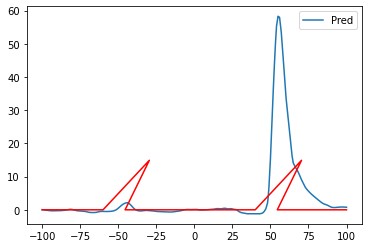

4001 0.521911462999924 loss =  -441256.875 reg =  90.29176073195723
4002 0.5272733060000974 loss =  -441254.9375 reg =  90.29207324338316
4003 0.5351493769999252 loss =  -441204.71875 reg =  90.29238571317491
4004 0.518554745000074 loss =  -441202.78125 reg =  90.29269814157969
4005 0.49664832400003434 loss =  -441107.9375 reg =  90.29301052884153
4006 0.4947504970000409 loss =  -441041.4375 reg =  90.2933228748165
4007 0.4917892980001852 loss =  -441039.5 reg =  90.29363517968724
4008 0.48034503400003814 loss =  -441102.1875 reg =  90.29394744363925
4009 0.4828912999996646 loss =  -441100.21875 reg =  90.29425966656966
4010 0.49339961099985885 loss =  -441033.75 reg =  90.2945718484069
4011 0.4951311220002026 loss =  -441096.4375 reg =  90.29488398939856
4012 0.4900676800002657 loss =  -441029.90625 reg =  90.29519608949697
4013 0.48580490099993767 loss =  -441092.625 reg =  90.29550814897135
4014 0.48654760999988866 loss =  -441026.0 reg =  90.29582016779321
4015 0.4846951029999218 l

4119 0.48587575299961827 loss =  -439838.40625 reg =  90.32840150481104
4120 0.48978613700001006 loss =  -439768.875 reg =  90.32871040370671
4121 0.49442733600017164 loss =  -439834.3125 reg =  90.32901927693709
4122 0.5016851469999892 loss =  -439764.75 reg =  90.32932812373079
4123 0.4798661730001186 loss =  -439830.25 reg =  90.32963694368334
4124 0.48741344300015044 loss =  -439760.625 reg =  90.32994573615672
4125 0.48317818400028045 loss =  -439758.59375 reg =  90.3302545008665
4126 0.4799914219997845 loss =  -439824.0625 reg =  90.33056323756425
4127 0.48165862799987735 loss =  -439822.09375 reg =  90.33087194575187
4128 0.4838643329999286 loss =  -439752.4375 reg =  90.33118062498859
4129 0.48120292800012976 loss =  -439750.375 reg =  90.33148927516743
4130 0.5092815670000164 loss =  -439815.96875 reg =  90.33179789619918
4131 0.48013049099972704 loss =  -439813.9375 reg =  90.33210648772852
4132 0.48646665799969924 loss =  -439811.875 reg =  90.33241504944259
4133 0.488070954

4237 0.4851415250000173 loss =  -439126.1875 reg =  90.36464472998786
4238 0.48123798999995415 loss =  -439055.125 reg =  90.36495009401311
4239 0.48123273200008043 loss =  -439122.4375 reg =  90.36525542861746
4240 0.49555196099981913 loss =  -439120.5625 reg =  90.36556073365163
4241 0.49448581899969213 loss =  -439049.46875 reg =  90.36586600898022
4242 0.4818005980000635 loss =  -439047.625 reg =  90.36617125476995
4243 0.4865123490003498 loss =  -439045.75 reg =  90.36647647116982
4244 0.47603395299984186 loss =  -439043.84375 reg =  90.3667816583129
4245 0.4811961010000232 loss =  -439059.5625 reg =  90.36708681631758
4246 0.4906675180000093 loss =  -439057.71875 reg =  90.36739194489908
4247 0.47660212499977206 loss =  -439055.9375 reg =  90.36769704380023
4248 0.48482733800028655 loss =  -439054.0625 reg =  90.3680021127884
4249 0.48617683300017234 loss =  -438983.0625 reg =  90.36830715165324
4250 0.4883367540001018 loss =  -439050.40625 reg =  90.36861216049451
4251 0.4852534

4355 0.5315083989999039 loss =  -438730.25 reg =  90.40048048008926
4356 0.513204451999627 loss =  -438799.125 reg =  90.4007825597774
4357 0.5444991669996853 loss =  -438797.46875 reg =  90.40108461153514
4358 0.5355264869999701 loss =  -438725.28125 reg =  90.40138663518563
4359 0.5126553059999424 loss =  -438723.625 reg =  90.40168863086679
4360 0.5115549699999065 loss =  -438721.96875 reg =  90.40199059869927
4361 0.5420637400002306 loss =  -438720.34375 reg =  90.40229253878823
4362 0.5173191860003499 loss =  -438789.25 reg =  90.40259445122486
4363 0.5125222369997573 loss =  -438787.625 reg =  90.40289633578678
4364 0.4896589270001641 loss =  -438786.0 reg =  90.40319819227041
4365 0.5015077799998835 loss =  -438573.3125 reg =  90.40350002048886
4366 0.4850301970000146 loss =  -438571.6875 reg =  90.40380182018605
4367 0.48051841800042894 loss =  -438499.4375 reg =  90.40410359112751
4368 0.4766101280001749 loss =  -438497.78125 reg =  90.40440533340029
4369 0.4791219700000511 lo

4473 0.5561223299996527 loss =  -437096.375 reg =  90.43591121717185
4474 0.5341100760001609 loss =  -437168.78125 reg =  90.43620945494885
4475 0.5225946880000265 loss =  -437093.375 reg =  90.43650764958535
4476 0.5273724869998659 loss =  -437165.78125 reg =  90.43680580084013
4477 0.4886391069999263 loss =  -437090.34375 reg =  90.43710390816966
4478 0.5126492480003435 loss =  -437088.8125 reg =  90.43740197140882
4479 0.4842903160001697 loss =  -437171.34375 reg =  90.43769999040795
4480 0.48959606700009317 loss =  -437096.0625 reg =  90.43799796462208
4481 0.4973581379999814 loss =  -437094.5625 reg =  90.4382958938849
4482 0.5268918589999885 loss =  -437166.9375 reg =  90.43859377804573
4483 0.5066963649996978 loss =  -437165.4375 reg =  90.43889161664202
4484 0.5141776119999122 loss =  -437090.09375 reg =  90.43918940925639
4485 0.5041561609996279 loss =  -437088.625 reg =  90.4394871558384
4486 0.5112754780002433 loss =  -437087.1875 reg =  90.43978485634187
4487 0.524812216000

KeyboardInterrupt: 

In [12]:
################################################################
# inverse optimization for 2d
################################################################
model = torch.load("catheter_plain_model_100", map_location=device)
print(count_params(model))

learning_rate = 0.01
epochs = 5001
step_size = 1000
gamma = 0.5
theta = torch.tensor(np.array([45,50,3], dtype=np.float), requires_grad=True)
optimizer = Adam([theta], lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
xx_mask = torch.linspace(-100, 100, 2001, dtype=torch.float).to(device)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    
    x, XC, YC = Theta2Mesh_2d(theta)
    
    
    out = model(x).flatten()
    
    # maximize negative mean
    loss = -torch.dot(out, xx_mask)
    reg = torch.norm(theta)
    loss_sum = loss + 1*reg
    loss_sum.backward()

    optimizer.step()
    scheduler.step()

    t2 = default_timer()
    print(ep, t2 - t1,  "loss = ", loss.item(), "reg = ", reg.item())

    if ep%step_size==0:
        theta_np = theta.detach().cpu().numpy()
        
        x2, x3, h = theta_np
        print("x2, x3, h = ", x2, x3, h)
        
        bottom_x, bottom_y = np.array([0-100, 40.0-100, x2-100, x3-100, 0, 40.0, x2, x3, 100.0]),  np.array([0, 0.0, h, 0, 0.0, 0, h, 0, 0.0])
        
        plt.figure()
        plt.plot(xx_mask.detach().cpu().numpy(), out.detach().cpu().numpy(), label="Pred")
        plt.plot(bottom_x, bottom_y, color="r")
        plt.legend()
        plt.show()